# 2. Review
2.1. Preprocessing: cleansing, text tokenization, stopword removal \
2.2. Most words \
2.3. Wordcloud \
2.4. Sentiment Dictionary : size, price, shipment \
2.5. Sentiment Dictionary : size option

## 2.1. Preprocessing: cleansing, text tokenization, stopword removal

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer # to create morpheme vector
from sklearn.feature_extraction.text import TfidfTransformer # change morpheme vector
from collections import Counter # for wordcloud
from IPython.display import Image
import pickle # save
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tag import pos_tag
import json
import ast

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

### konlpy 
To install konlpy, JAVA is required. Please follow the instructions listed in the below link. \
https://konlpy.org/en/latest/install/

Also, this library often does not work in the VS code. 
Anaconda is recommended.

In [3]:
import konlpy
from konlpy.tag import Kkma
from konlpy.tag import Okt
from konlpy.utils import pprint

In [4]:
# read review df
path = r"C:\Users\z1one\OneDrive\바탕 화면\Portfolio_desktop\eda\output\sample_df.xlsx"
df = pd.read_excel(path, index_col=0)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.reset_index(drop=True, inplace=True)
df.head(3)

,ID,Date,Grade,Text,Option,Size,ProductNum
0,날까,2023.04.08,4,쿠폰써서 2만원정도에 6벌이면 정말 싸요. 싼만큼 마감이 안좋은 부분도 있네요. 어...,"White 6-pack, 6, Medium",비공개,3569992365
1,newr*****,2023.03.27,5,옷에 비침도 크게 없고 사이즈도 넉넉해서 좋습니다. 이번 여름까지 무난하게 잘 입을...,"XX-Large, 6, White 6-pack",비공개,3569992365
2,soch*****,2023.03.31,4,잘 알려진 브랜드입니다.면이 얇고 빨면 줄기도 합니다.올 여름 편하게 입으려고 구매...,"X-Large, 6, Charcoal Heather 6-pack",비공개,3569992365


Mean of Grade 4.5635551834798385


<Axes: title={'center': 'Ratings'}, xlabel='Grade'>

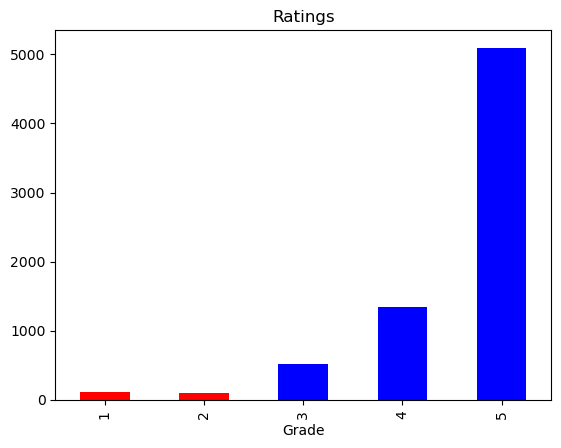

In [5]:
# graph of ratings
print("Mean of Grade", df["Grade"].mean())
# Grade 열의 값 빈도를 계산하고 정렬하여 그래프로 출력
df["Grade"].value_counts().sort_index().plot(
    kind="bar",
    title="Ratings",
    color=['r', 'r', 'b', 'b', 'b']
)

In [6]:
# check null data
df.isnull().sum()

ID            0
Date          0
Grade         0
Text          0
Option        0
Size          0
ProductNum    0
dtype: int64

In [7]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7167 entries, 0 to 7166
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          7167 non-null   object
 1   Date        7167 non-null   object
 2   Grade       7167 non-null   int64 
 3   Text        7167 non-null   object
 4   Option      7167 non-null   object
 5   Size        7167 non-null   object
 6   ProductNum  7167 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 392.1+ KB


In [8]:
okt = Okt()
kkma = Kkma()

# regular expressioin function
def apply_regular_expression(text):
    kor = re.compile('[^ ㄱ-ㅣ 가-힣]')  # Korean extraction rules: Korean including spaces (1)
    result = kor.sub("",text) # apply kor rule
    return result

# stopwords
cwd = os.getcwd()
stopwords_directory = 'materials'
stopwords_file = 'kor_stopwords.xlsx'
stopwords_path = os.path.join(cwd, stopwords_directory, stopwords_file)
df_stopwords = pd.read_excel(stopwords_path)
stopwords_list = df_stopwords[0].tolist()

stop = " "
stop_list = stop.split(',')

def apply_stopwords(sample_text):
    #  1) remove space
    remove_blank = re.compile(r'\W*\b\w\b')
    remove_mark = remove_blank.sub('', sample_text).replace('.', '')
    # print(remove_mark)

    # 2) regular
    regular = apply_regular_expression(remove_mark)
    # print(regular)
    
    # 3) remove stopwords
    regular = apply_regular_expression(remove_mark)
    tok = okt.morphs(regular)
    tok_str = ' '.join(tok)
    shortword = re.compile(r'\W*\b\w{1}\b')
    third_processed = shortword.sub('', tok_str)
    third_processed = okt.morphs(third_processed)
    result = []
    
    for w in third_processed:
        if w not in stopwords_list:
            result.append(w)
    return result

df["FilteredText"] = 0
df['FilteredText'] = df['Text']
df["FilteredText"] = df["FilteredText"].astype('str')

def filteredtext(df):
    for i in range(len(df)):
        text = df.loc[i,'FilteredText']
        filtered_text = apply_stopwords(text)
        # Join the filtered_text list into a single string
        filtered_text_str = ' '.join(filtered_text)
        df.loc[i,'FilteredText'] = filtered_text_str
        
filteredtext(df)
df.to_excel("Filtered_stopwords.xlsx")
df.head(2)

,ID,Date,Grade,Text,Option,Size,ProductNum,FilteredText
0,날까,2023.04.08,4,쿠폰써서 2만원정도에 6벌이면 정말 싸요. 싼만큼 마감이 안좋은 부분도 있네요. 어...,"White 6-pack, 6, Medium",비공개,3569992365,쿠폰 써서 정도 벌이 정말 싸요 싼만큼 마감 안좋은 부분 있네요 어깨 재봉 씹힌것도...
1,newr*****,2023.03.27,5,옷에 비침도 크게 없고 사이즈도 넉넉해서 좋습니다. 이번 여름까지 무난하게 잘 입을...,"XX-Large, 6, White 6-pack",비공개,3569992365,비침도 크게 없고 사이즈 넉넉해서 좋습니다 여름 무난 하게 같아요


## 2.2. Mode morepheme

In [9]:
# check JAVA_HOME path before using KONLPY
print('JAVA_HOME' in os.environ)

True


In [10]:
# Morphological analysis okt.pos(text)
text = df['Text'][0]

def extract_verbs(text):
    pos = okt.pos(text)
    verbs = [word for word, tag in pos if tag in ['Verb']]
    return verbs
def extract_adj(text):
    pos = okt.pos(text)
    adjs = [word for word, tag in pos if tag in ['Adjective']]
    return adjs

# print('Normalize: ',okt.normalize(text))
# print('Overall:', okt.pos(text)) # Morphological analysis okt.pos(text)
# print('Nouns:',okt.nouns(text))
# print('Verbs:', extract_verbs(text))
# print('Adjectives:', extract_adj(text))

In [11]:
#  extract morpheme 
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    
    result = []
    
    for i in pos:
        result.append(f'{i[0]}/{i[1]}')
        
    return result

# morpheme vector  벡터 
index_vectorizer = CountVectorizer(tokenizer = lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df["Text"].astype(str).tolist())

df["Text_Morpheme"] = 0
df.head(1)

,ID,Date,Grade,Text,Option,Size,ProductNum,FilteredText,Text_Morpheme
0,날까,2023.04.08,4,쿠폰써서 2만원정도에 6벌이면 정말 싸요. 싼만큼 마감이 안좋은 부분도 있네요. 어...,"White 6-pack, 6, Medium",비공개,3569992365,쿠폰 써서 정도 벌이 정말 싸요 싼만큼 마감 안좋은 부분 있네요 어깨 재봉 씹힌것도...,0


In [12]:
df["Text_Morpheme"] = df["Text_Morpheme"].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7167 entries, 0 to 7166
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             7167 non-null   object
 1   Date           7167 non-null   object
 2   Grade          7167 non-null   int64 
 3   Text           7167 non-null   object
 4   Option         7167 non-null   object
 5   Size           7167 non-null   object
 6   ProductNum     7167 non-null   int64 
 7   FilteredText   7167 non-null   object
 8   Text_Morpheme  7167 non-null   object
dtypes: int64(2), object(7)
memory usage: 504.1+ KB


In [13]:
for i in range(0, df.shape[0]): 
    df.at[i, "Text_Morpheme"] = okt.pos(str(df.loc[i, 'Text']))

df.head(1)

,ID,Date,Grade,Text,Option,Size,ProductNum,FilteredText,Text_Morpheme
0,날까,2023.04.08,4,쿠폰써서 2만원정도에 6벌이면 정말 싸요. 싼만큼 마감이 안좋은 부분도 있네요. 어...,"White 6-pack, 6, Medium",비공개,3569992365,쿠폰 써서 정도 벌이 정말 싸요 싼만큼 마감 안좋은 부분 있네요 어깨 재봉 씹힌것도...,"[(쿠폰, Noun), (써서, Verb), (2만원, Number), (정도에, ..."


In [14]:
# combine all values in Text_Morpheme to find the mode value
combined_list = df['Text_Morpheme'].sum()

In [15]:
# A function that returns the most frequently occurring word and number of occurrences
def find_most_common_words(lst, pos): # N: noun, V:verb, J: adjective, A:adverb
    pos_dict = defaultdict(int)

    for word, tag in lst:
        if tag.startswith(pos):
            pos_dict[(tag, word)] += 1

    if pos_dict:
        most_common = max(pos_dict.items(), key=lambda x: x[1])
        return most_common[0][0], most_common[0][1], most_common[1]
    else:
        return "No words found for the specified part of speech."

# Specify part of speech as variable
pos_to_find = 'A'  # For example, if you want to find a noun (N)
result = find_most_common_words(combined_list, pos_to_find)
if result != "No words found for the specified part of speech.":
    part_of_speech, word, count = result
    print(f"Most common {part_of_speech} :'{word}', {count} ")
else:
    print(result)


Most common Adjective :'좋아요', 984 


In [16]:
# get_most_common_words_by_pos at glance
def get_most_common_words_by_pos(combined_list):
    # Initialize dictionary to store words appearing by part of speech
    pos_count = {pos: (None, 0) for _, pos in combined_list}
    
    # Count the words and the number of times and store them in the dictionary
    for word, pos in combined_list:
        count = pos_count[pos][1] + 1
        pos_count[pos] = (word, count)

    # Return the word and number of occurrences for each part of speech
    result = []
    for pos, (word, count) in pos_count.items():
        if word is not None:
            result.append((pos, word, count))
    return result
get_most_common_words_by_pos(combined_list)

[('Noun', '제외', 29005),
 ('Verb', '늘어나네요', 11537),
 ('Number', '100', 3471),
 ('Foreign', 'ㆍ', 259),
 ('Josa', '하고', 11396),
 ('Punctuation', '.', 5568),
 ('Adjective', '좋습니다', 10796),
 ('Alpha', 'Xl', 1548),
 ('Determiner', '한', 631),
 ('Adverb', '적어도', 1537),
 ('Suffix', '네', 564),
 ('Eomi', '네요', 80),
 ('Conjunction', '그런데', 94),
 ('VerbPrefix', '딱', 371),
 ('KoreanParticle', 'ㅡㅗㅎ', 479),
 ('Modifier', '팔', 1006),
 ('Exclamation', '아', 56),
 ('PreEomi', '퍼', 8),
 ('URL', 'https://marumaru219.com/', 1)]

In [17]:
def most_common_nouns(combined_list):
    #  Extract and count all noun 
    noun_count = {}
    for word, pos in combined_list:
        if pos == 'Noun':
            if word in noun_count:
                noun_count[word] += 1
            else:
                noun_count[word] = 1
    
    # Select the top 10 most frequently occurring noun words
    top_nouns = sorted(noun_count.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Convert to (part of speech, word, number of occurrences)
    return [(noun, count) for noun, count in top_nouns]

def most_common_verbs(combined_list):
    #  Extract and count all verbs 
    verb_count = {}
    for word, pos in combined_list:
        if pos == 'Verb':
            if word in verb_count:
                verb_count[word] += 1
            else:
                verb_count[word] = 1
    top_verbs = sorted(verb_count.items(), key=lambda x: x[1], reverse=True)[:10]
    return [(verb, count) for verb, count in top_verbs]

def most_common_adjs(combined_list):
    adj_count = {}
    for word, pos in combined_list:
        if pos == 'Adjective':
            if word in adj_count:
                adj_count[word] += 1
            else:
                adj_count[word] = 1
    top_adjs = sorted(adj_count.items(), key=lambda x: x[1], reverse=True)[:30]
    return [( adj, count) for adj, count in top_adjs]

print('most common nouns:')
print(most_common_nouns(combined_list))
print('most common verbs:')
print(most_common_verbs(combined_list))
print('most common adjs:')
print(most_common_adjs(combined_list))

most common nouns:
[('사이즈', 2054), ('배송', 753), ('가격', 679), ('구매', 512), ('옷', 504), ('생각', 430), ('주문', 401), ('좀', 373), ('제품', 360), ('재질', 311)]
most common verbs:
[('잘', 648), ('입기', 320), ('합니다', 298), ('했는데', 222), ('크네요', 192), ('입는데', 176), ('했습니다', 161), ('해서', 160), ('하세요', 148), ('감사합니다', 146)]
most common adjs:
[('좋아요', 984), ('입니다', 496), ('좋습니다', 384), ('좋고', 362), ('좋네요', 322), ('만족합니다', 288), ('좋은', 272), ('같아요', 261), ('저렴하게', 199), ('빠르고', 194), ('편하게', 163), ('작게', 141), ('같습니다', 104), ('저렴한', 99), ('괜찮아요', 97), ('같네요', 97), ('빠른', 87), ('같은', 86), ('얇고', 78), ('저렴하고', 66), ('얇은', 59), ('있어서', 59), ('있습니다', 58), ('넉넉하고', 58), ('있는', 54), ('넉넉하게', 54), ('부드럽고', 54), ('괜찮습니다', 53), ('편하고', 53), ('나쁘지', 51)]


## 2.3. Wordcloud

In [27]:
nouns = df['Text'].apply(lambda x: kkma.nouns(str(x)))
nouns = nouns.explode()
df_word = pd.DataFrame({'word' : nouns})
df_word['count'] = df_word['word'].str.len()
df_word = df_word.query('count > = 2')
df_word = df_word.groupby('word', as_index = False).count().sort_values('count', ascending = False)
df_word

,word,count
1768,사이즈,1609
1532,배송,687
478,가격,646
718,구매,484
1271,만족,447
...,...,...
1584,베이비,1
1586,베이스티,1
1588,베이지색,1
1589,베이직,1


### translation

In [28]:
# from googletrans import Translator # pip install --upgrade googletrans==4.0.0-rc1

# translator = Translator()
# # Function to translate a word
# def translate_word(word):
#     translation = translator.translate(word, dest='en', src='ko')
#     return translation.text

# # Apply the translation function to the 'word' column
# df_word['translated_word'] = df_word['word'].apply(translate_word)

# # Print the translated DataFrame
# df_word.head(2)

In [29]:
df_word['word']

1768       사이즈
1532        배송
478         가격
718         구매
1271        만족
         ...  
1584       베이비
1586      베이스티
1588      베이지색
1589       베이직
3607    힝ㅅ들것같아
Name: word, Length: 3608, dtype: object

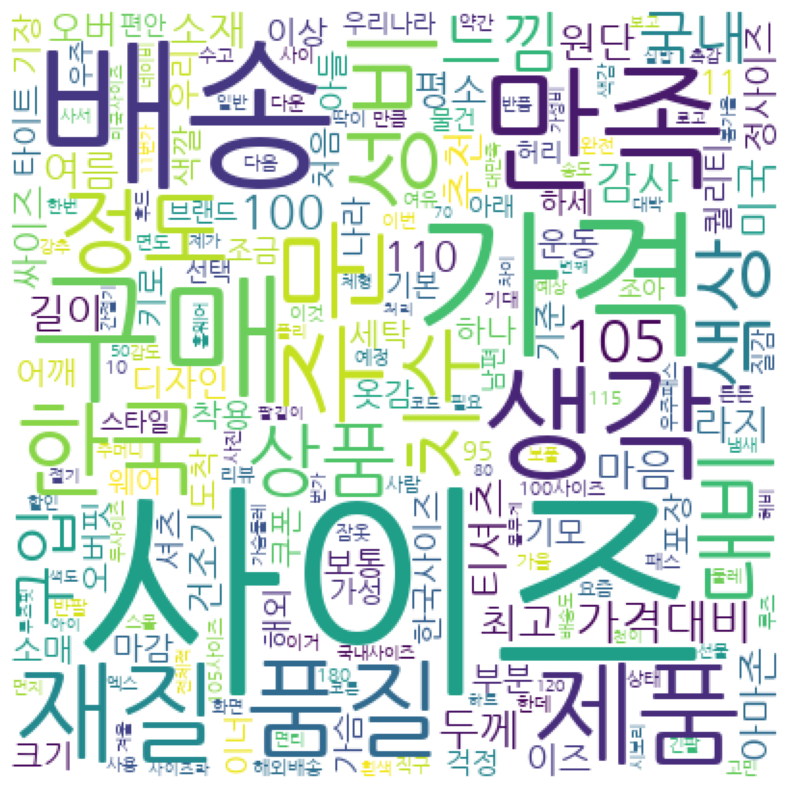

In [30]:
dic_word = df_word.set_index('word').to_dict()['count']
# font path
cwd = os.getcwd()
font_directory = 'materials'
font_file = 'NanumGothic.ttf'
font_path = os.path.join(cwd, font_directory, font_file)

wc = WordCloud(random_state = 123, width = 400,font_path = font_path,
               height = 400, background_color = 'white')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
plt.savefig('review_text_wordcloud') # 파일 저장

## 2.4. Sentiment Dictionary
Korean Sentiment Dictionary from KOSAC 
* https://github.com/mrlee23/KoreanSentimentAnalyzer
* https://codingstudyroom.tistory.com/entry/%EC%9B%B9%ED%88%B0-%EC%8A%B9%EA%B2%A9-%ED%99%95%EB%A5%A0-%EC%98%88%EC%B8%A1-%EC%8B%9C%EC%8A%A4%ED%85%9C-%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8-kosac%EC%82%AC%EC%A0%84%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D-%EA%B4%91%EC%A3%BC%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%ED%95%99%EC%9B%90
* It uses java 
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

In [31]:
# Define the KnuSL class
class KnuSL:
    def __init__(self):
        with open('materials/SentiWord_info.json', encoding='utf-8-sig', mode='r') as f:
            self.data = json.load(f)

    def data_list(self, wordname):
        result = ['None', 'None']
        for i in range(len(self.data)):
            if self.data[i]['word'] == wordname:
                result.pop()
                result.pop()
                result.append(self.data[i]['word_root'])
                result.append(self.data[i]['polarity'])

        r_word = result[0]
        s_word = result[1]
        return r_word, s_word

# Create an instance of the KnuSL class
ksl = KnuSL()

# Define a function to rate a list of words
def rate_list(cell):
    total_rating = 0
    for i in cell:
        tokens = okt.morphs(i)  # Tokenize the Korean text
        for token in tokens:
            r_word, s_word = ksl.data_list(token)
            if r_word != "None":
                total_rating += int(s_word)
    return total_rating

# Define a function to apply the rating to the DataFrame
def apply_rate(x):
    if x == 0:
        return 0
    else:
        return rate_list(x)

# Apply the rating calculation to the DataFrame
df["Rate"] = df["FilteredText"].apply(apply_rate)

# Calculate the length of the text in the "FilteredText" column
df["FilteredLen"] = df["FilteredText"].apply(lambda x: len(x) if x != 0 else 0)

# Save the DataFrame to an Excel file
df.to_excel("Rate_check.xlsx")

Rate
 0    5663
 1     602
-2     535
-1     147
 2      78
-4      56
-3      41
 3      17
-5      13
-6      11
-8       2
 4       2
Name: count, dtype: int64


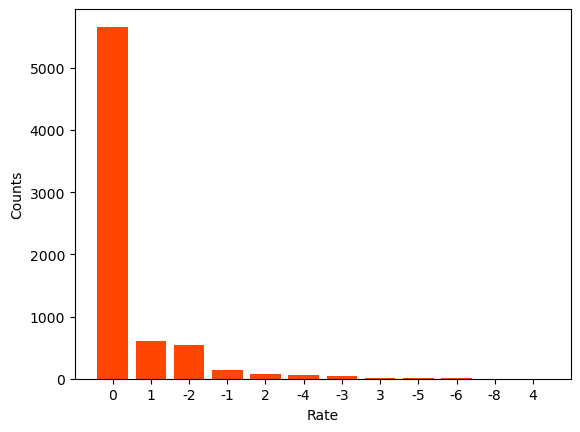

In [49]:
# Get value counts for the "Rate" column
value_counts = df['Rate'].value_counts()
print(value_counts)
df_counts = value_counts.to_frame().reset_index()
df_counts["Rate"] = df_counts["Rate"].astype(str)
# Create a bar plot
plt.bar(df_counts["Rate"], df_counts["count"],color = 'orangered' )
plt.xlabel("Rate")
plt.ylabel("Counts")

plt.show()

In [33]:
# 1) correlation between Grade and rate
corr = df[['Grade', 'Rate']].corr()
print(corr)

          Grade      Rate
Grade  1.000000  0.071739
Rate   0.071739  1.000000


In [34]:
# 2) correlation between Grade and 'FilteredLen
corr = df[['Grade', 'FilteredLen']].corr()
print(corr)

                Grade  FilteredLen
Grade        1.000000    -0.092514
FilteredLen -0.092514     1.000000


In [35]:
# 3) correltation between Rate and FilteredLen'
corr = df[['Rate', 'FilteredLen']].corr()
print(corr)

                 Rate  FilteredLen
Rate         1.000000    -0.176155
FilteredLen -0.176155     1.000000


In [64]:
# check correlation between Grade and Rate when size, price, shipment is mentioned
nouns = df['Text'].apply(lambda x: kkma.nouns(str(x)))
nouns = nouns.explode()
df_word = pd.DataFrame({'word' : nouns})
df_word['count'] = df_word['word'].str.len()
df_word.word=df_word.word.astype(str)
df_word = df_word.query('count > = 2')

size_exist=df_word.index[df_word["word"]=="사이즈"].tolist()
price_exist=df_word.index[df_word["word"]=="가격"].tolist()
shipment_exist=df_word.index[df_word["word"]=="배송"].tolist()

size_exist_df = df.iloc[size_exist]
price_exist_df = df.iloc[price_exist]
shipment_exist_df = df.iloc[shipment_exist]

In [73]:
corr = size_exist_df[['Grade', 'Rate']].corr()
print(corr)

          Grade      Rate
Grade  1.000000  0.070152
Rate   0.070152  1.000000


In [74]:
corr = price_exist_df[['Grade', 'Rate']].corr()
print(corr)

          Grade      Rate
Grade  1.000000  0.106422
Rate   0.106422  1.000000


In [75]:
corr = shipment_exist_df[['Grade', 'Rate']].corr()
print(corr)

          Grade      Rate
Grade  1.000000  0.199187
Rate   0.199187  1.000000


In [80]:
# Negative Rate
negative_rate_df = df[df["Rate"] < 0]

# Function to check if a keyword is mentioned in text
def has_keyword(text, keyword):
    if isinstance(text, str) and keyword in text:
        return True
    return False

# Count whether 'price' is mentioned in negative evaluations
negative_rate_df['has_price'] = negative_rate_df['FilteredText'].apply(lambda x: has_keyword(x, '가격'))
num_neg_price = (negative_rate_df['has_price'] == True).sum()
print('Price:', num_neg_price)

# Count whether 'size' is mentioned in negative evaluations
negative_rate_df['has_size'] = negative_rate_df['FilteredText'].apply(lambda x: has_keyword(x, '사이즈'))
num_neg_size = (negative_rate_df['has_size'] == True).sum()
print('Size:', num_neg_size)

# Count whether 'shipment' is mentioned in negative evaluations
negative_rate_df['has_shipment'] = negative_rate_df['FilteredText'].apply(lambda x: has_keyword(x, '배송'))
num_neg_shipment = (negative_rate_df['has_shipment'] == True).sum()
print('Shipment:', num_neg_shipment)

# Export negative rate data to Excel
negative_rate_df.to_excel("negative_rate_check.xlsx")

# Positive Rate
positive_rate_df = df[df["Rate"] > 0]

# Count whether 'size' is mentioned in positive evaluations
positive_rate_df['has_size'] = positive_rate_df['FilteredText'].apply(lambda x: 1 if '사이즈' in x else 0)
num_true_size = (positive_rate_df['has_size'] == 1).sum()
print('Size:', num_true_size)

# Count whether 'price' is mentioned in positive evaluations
positive_rate_df['has_price'] = positive_rate_df['FilteredText'].apply(lambda x: 1 if '가격' in x else 0)
num_true_price = (positive_rate_df['has_price'] == 1).sum()
print('Price:', num_true_price)

# Count whether 'shipment' is mentioned in positive evaluations
positive_rate_df['has_shipment'] = positive_rate_df['FilteredText'].apply(lambda x: 1 if '배송' in x else 0)
num_true_shipment = (positive_rate_df['has_shipment'] == 1).sum()
print('Shipment:', num_true_shipment)


Price: 102
Size: 282
Shipment: 113
Size: 311
Price: 81
Shipment: 71


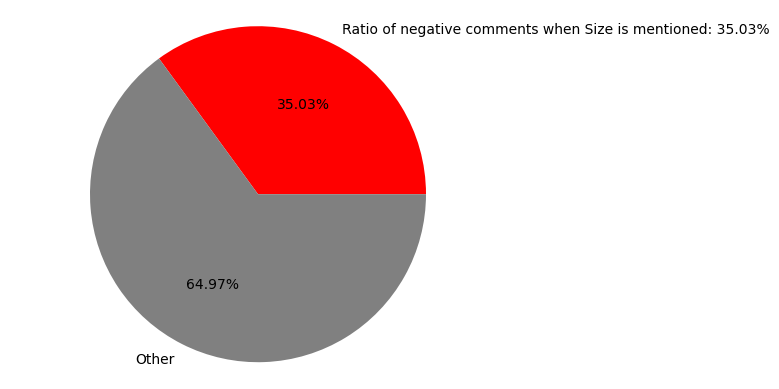

In [88]:
neg_size = round((num_neg_size / len(negative_rate)) * 100, 2)
label = f"Ratio of negative comments when Size is mentioned: {neg_size}%"

labels = [label, "Other"]
sizes = [neg_size, 100 - neg_size]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()


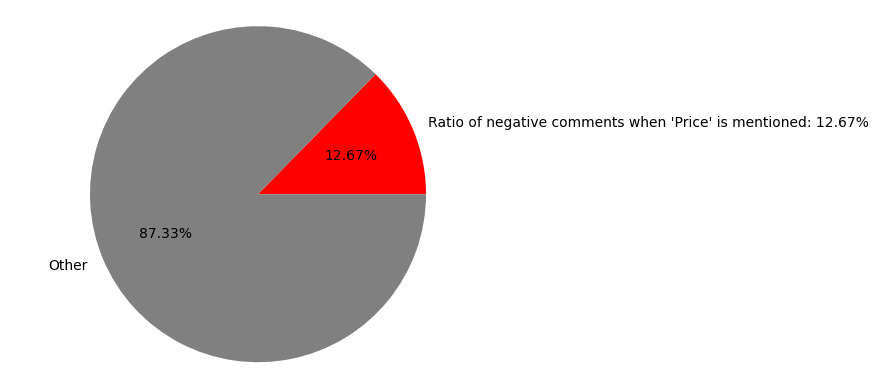

In [89]:
# Ratio of negative comments when 'Price' is mentioned

neg_price = round((num_neg_price / len(negative_rate)) * 100, 2)
label = f"Ratio of negative comments when 'Price' is mentioned: {neg_price}%"

labels = [label, "Other"]
sizes = [neg_price, 100 - neg_price]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()

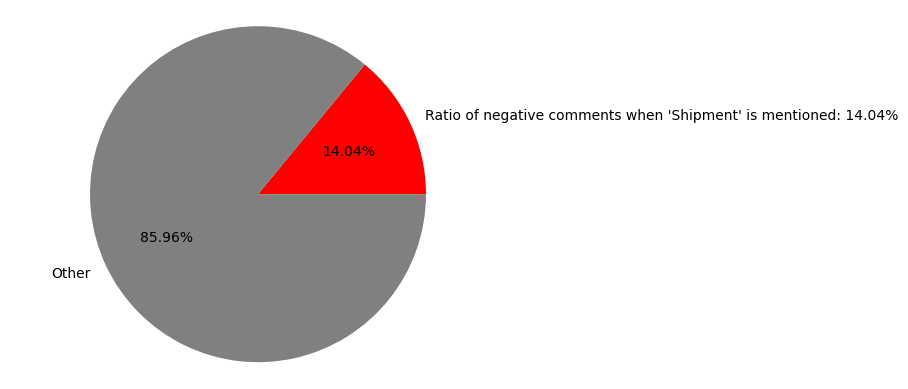

In [90]:
# ratio of negative comments when 'Shipment' is mentioned
neg_shipment = round((num_neg_shipment / len(negative_rate)) * 100, 2)
label = f"Ratio of negative comments when 'Shipment' is mentioned: {neg_shipment}%"

labels = [label, "Other"]
sizes = [neg_shipment, 100 - neg_shipment]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()


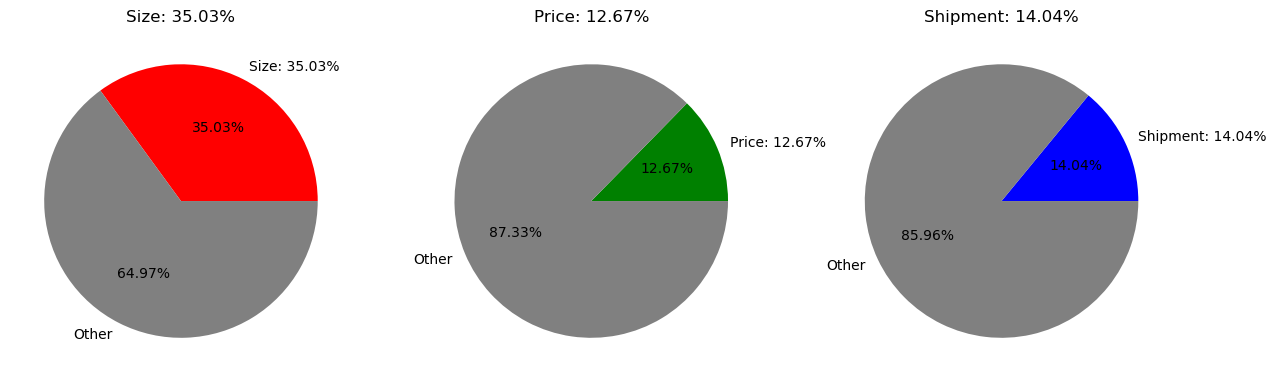

In [91]:
# # Calculate the percentages
# neg_size = round((num_neg_size / len(negative_rate)) * 100, 2)
# neg_price = round((num_neg_price / len(negative_rate)) * 100, 2)
# neg_shipment = round((num_neg_shipment / len(negative_rate)) * 100, 2)

# # Create labels and sizes for the pie charts
# labels = [
#     f"Size: {neg_size}%",
#     f"Price: {neg_price}%",
#     f"Shipment: {neg_shipment}%"
# ]

# sizes = [neg_size, neg_price, neg_shipment]
# colors = ['red', 'green', 'blue']

# def autopct_format(pct):
#     return '{:.2f}%'.format(pct)

# # Create subplots
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# # Create pie charts for each category
# for i in range(3):
#     axs[i].pie([sizes[i], 100 - sizes[i]], labels=[labels[i], "Other"], autopct=autopct_format, colors=[colors[i], 'gray'])
#     axs[i].set_title(labels[i])

# plt.show()

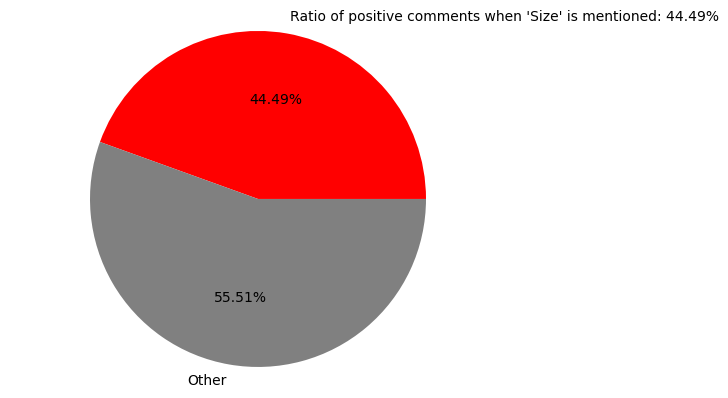

In [94]:
# Ratio of positive comments when 'Size' is mentioned:
pos_size = round((num_true_size / len(positive_rate_df)) * 100, 2)
label = f"Ratio of positive comments when 'Size' is mentioned: {pos_size}%"

labels = [label, "Other"]
sizes = [pos_size, 100 - pos_size]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()

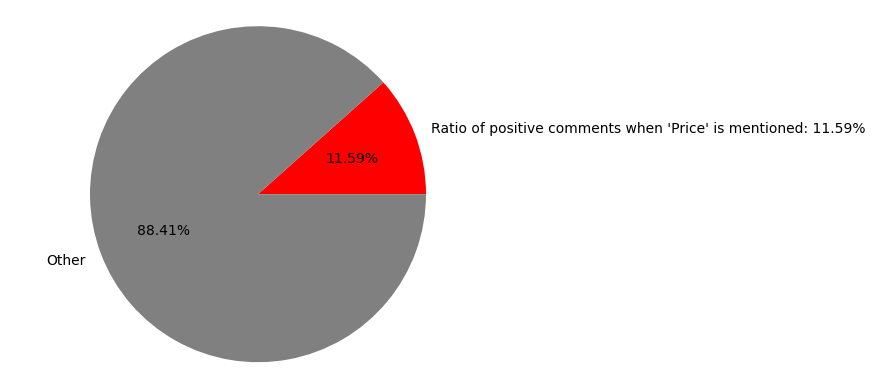

In [95]:
# Ratio of positive comments when 'Price' is mentioned
pos_price = round((num_true_price / len(positive_rate_df)) * 100, 2)
label = f"Ratio of positive comments when 'Price' is mentioned: {pos_price}%"

labels = [label, "Other"]
sizes = [pos_price, 100 - pos_price]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()

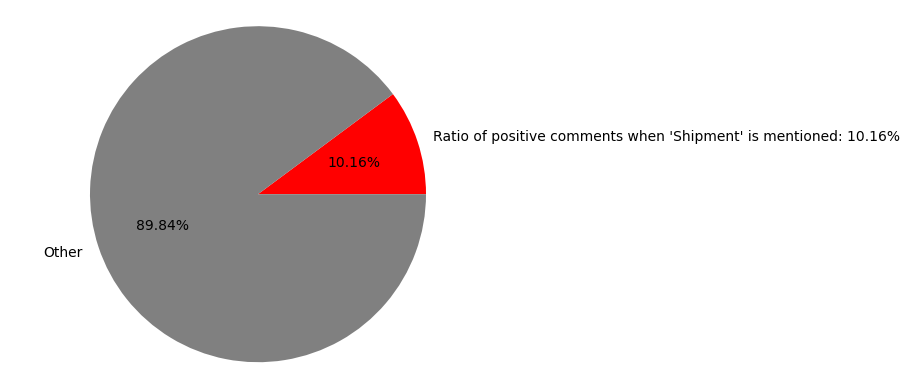

In [97]:
# Ratio of positive comments when 'Shipment' is mentioned
pos_shipment = round((num_true_shipment / len(positive_rate_df)) * 100, 2)
label = f"Ratio of positive comments when 'Shipment' is mentioned: {pos_shipment}%"

labels = [label, "Other"]
sizes = [pos_shipment, 100 - pos_shipment]
colors = ['red', 'gray']

def autopct_format(pct):
    return '{:.2f}%'.format(pct)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct=autopct_format, colors=colors)
ax.axis('equal')

plt.show()

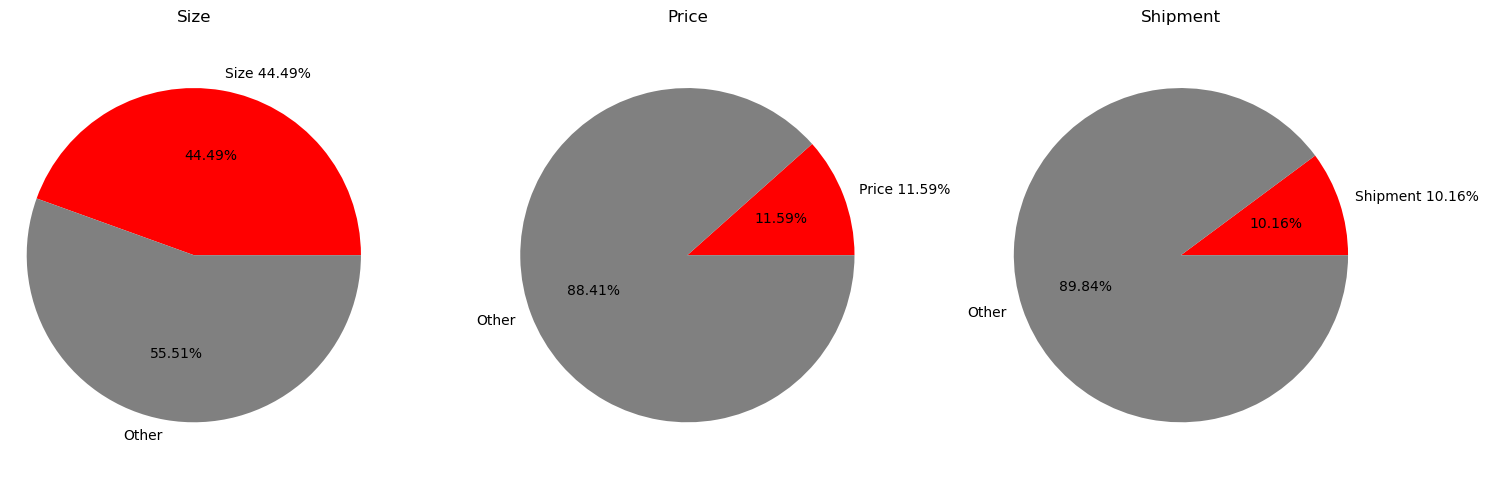

In [159]:
import matplotlib.pyplot as plt

# Ratio of positive comments when 'Size' is mentioned:
pos_size = round((num_true_size / len(positive_rate_df)) * 100, 2)
label_size = f"Size {pos_size}%"

# Ratio of positive comments when 'Price' is mentioned
pos_price = round((num_true_price / len(positive_rate_df)) * 100, 2)
label_price = f"Price {pos_price}%"

# Ratio of positive comments when 'Shipment' is mentioned
pos_shipment = round((num_true_shipment / len(positive_rate_df)) * 100, 2)
label_shipment = f"Shipment {pos_shipment}%"

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Pie chart for 'Size'
labels_size = [label_size, "Other"]
sizes_size = [pos_size, 100 - pos_size]
colors_size = ['red', 'gray']

axs[0].pie(sizes_size, labels=labels_size, autopct=autopct_format, colors=colors_size)
axs[0].set_title('Size', fontsize=12)  # Increase font size here
axs[0].axis('equal')

# Pie chart for 'Price'
labels_price = [label_price, "Other"]
sizes_price = [pos_price, 100 - pos_price]
colors_price = ['red', 'gray']

axs[1].pie(sizes_price, labels=labels_price, autopct=autopct_format, colors=colors_price)
axs[1].set_title('Price', fontsize=12)  # Increase font size here
axs[1].axis('equal')

# Pie chart for 'Shipment'
labels_shipment = [label_shipment, "Other"]
sizes_shipment = [pos_shipment, 100 - pos_shipment]
colors_shipment = ['red', 'gray']

axs[2].pie(sizes_shipment, labels=labels_shipment, autopct=autopct_format, colors=colors_shipment)
axs[2].set_title('Shipment', fontsize=12)  # Increase font size here
axs[2].axis('equal')

# Adjust layout
plt.tight_layout()

# Show the combined figure
plt.show()


## 2.5. Size Option 

In [131]:
# correlation between Grade and Rate when the customer put their size option
df.loc[:,"Size" ].apply(lambda x : 0 if x == "비공개" else x )
no_size_df = df[df["Size"] == 0]
no_size_df.to_excel("no_size.xlsx")

size_df = df[df["Size"]!= 0]
size_df.to_excel("size.xlsx")
size_df["Size"] = size_df["Size" ].apply(lambda x : 0 if x == "비공개" else x )
size_df[size_df["Size"] != 0]

size_df["Option"] = size_df["Option"].apply(lambda x : size_df["Option"] == size_df["Size"] if x == 0 else x )
size_list = size_df[size_df["Size"] != 0].index

In [133]:
corr = size_df[['Grade', 'Rate']].corr()
print(corr)

          Grade      Rate
Grade  1.000000  0.100424
Rate   0.100424  1.000000


In [137]:
# Option 5, Size 6
for i in size_list:
    size_df.loc[i, 'Option'] = size_df.loc[i, 'Size']
size_df.head(3)

,ID,Date,Grade,Text,Option,Size,ProductNum,FilteredText,Text_Morpheme,Rate,FilteredLen,value_index
8,jik1***,2023.04.21,5,한국 면티에비에 좀 거친느낌이 있긴 하지만 가성비좋고 막입는용도로 대량규매한다면 추...,"3X-Large, White 6-pack, 6","3X-Large, White 6-pack, 6",3569992365,한국 면티 거친 느낌 있긴 가성 좋고 입는용 도로 대량 규매 추천 합니다,"[(한국, Noun), (면티, Noun), (에, Josa), (비, Noun),...",0,40,0
9,kwan********,2021.11.24,5,두번째 구매입니다. 엑스라지는 많이 커서 라지로 또 구매,"Large, White","Large, White",3569992365,두번째 구매 입니다 엑스 라지 많이 커서 라지 구매,"[(두번째, Noun), (구매, Noun), (입니다, Adjective), (....",0,28,0
303,진소리,2023.04.07,5,편하고 막입기 좋아요운동할때입으니 딱 좋네요봄 가을용 굿,"Black (2-pack), X-Large, 2","Black (2-pack), X-Large, 2",3556338225,편하고 입기 좋아요 운동 입으니 좋네요 가을,"[(편하고, Adjective), (막, Noun), (입기, Verb), (좋아요...",1,24,1


In [119]:
# Next, update the "Option" column using the condition
size_df["Option"] = size_df.apply(lambda row: row["Size"] if (row["Option"] == 0) else row["Option"], axis=1)

# Finally, update the specific rows in the "Option" column based on a list of indices
for i in size_list:
    size_df.loc[i, 'Option'] = size_df.loc[i, 'Size']

<Axes: xlabel='Option_Size'>

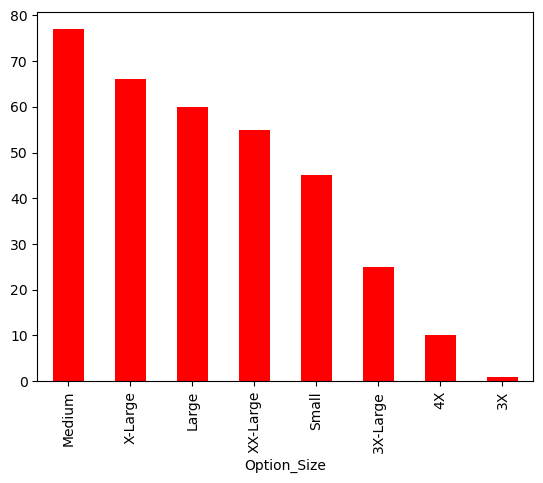

In [141]:
# Option에서 사이즈 정보만 뽑아오기
data = size_df["Option"]
sizes = []
def find_size(x):    
    pattern = r'\b(\d{1,2}[XSLM]{0,3}(-\d{1,2}[XSLM]{0,3})?)\b'   
    matches = re.findall(pattern, x)
    if matches:
        size = matches[0][0]
        return size 
    
    
def find_size_re(x):     
    pattern = r'\b(2X-Large|3X-Large|X-Large|XX-Large|Small|Medium|Large|3X|4X)\b'

    matches = re.findall(pattern, x)
    if matches:
        size = matches[0]
        return size
size_df["Option_Size"] = size_df["Option"].apply(lambda x : find_size_re(x) )   
size_df[size_df["Option_Size"].isnull()]
temp_size_df = size_df.reset_index()    
size_df = temp_size_df.drop("index", axis = 1)
size_df[size_df["Option_Size"].isnull()]

size_array = size_df["Option_Size"].unique()
size_df["Option_Size"].value_counts()
size_counts = size_df["Option_Size"].value_counts()
size_counts.plot(kind = 'bar', color = 'red')

In [148]:
# size_df.to_excel("size_final.xlsx")
# compare option choices in terms of rate 
print('Mean of Grade with size options : ',size_df["Grade"].mean())
print('Value Counts of Grade with size options: ', df["Grade"].value_counts())
# Grade Positive 5 points, negative 4 points or less
# Rate positive positive number, negative negative number

# 1) Negative Rate when Grade is 5 points

# 2) Grade negative, Rate negative
print('Values of Rate')
print(size_df["Rate"].value_counts())


Mean of Grade with size options :  4.568115942028985
Value Counts of Grade with size options:  Grade
5    5095
4    1341
3     517
1     111
2     103
Name: count, dtype: int64
Values of Rate
Rate
 0    243
 1     44
-2     29
 2      8
-3      6
-1      6
-4      5
-6      3
-5      1
Name: count, dtype: int64


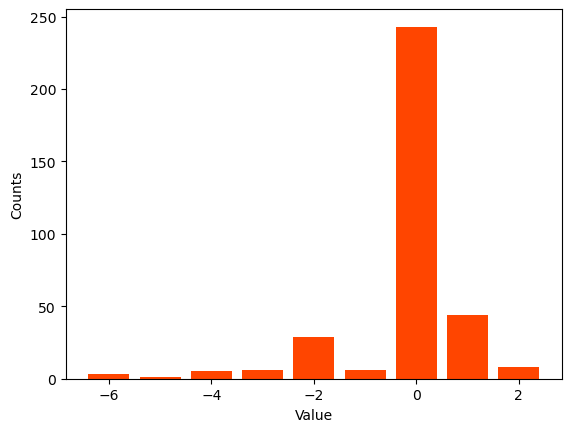

In [153]:
value_counts = size_df['Rate'].value_counts()
df_counts = value_counts.to_frame().reset_index()
plt.bar(df_counts["Rate"], df_counts["count"],color = 'orangered' )
plt.xlabel("Value")
plt.ylabel("Counts")

plt.show()

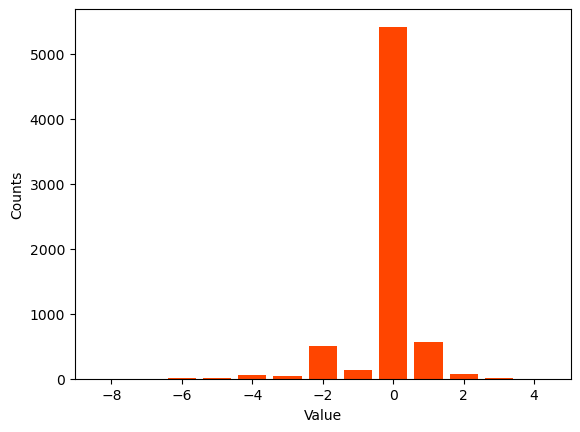

In [155]:
no_size_value_counts = no_size_df["Rate"].value_counts()
no_size_value_counts = no_size_value_counts.to_frame().reset_index()
plt.bar(no_size_value_counts["Rate"], no_size_value_counts["count"],color = 'orangered' )
plt.xlabel("Value")
plt.ylabel("Counts")

plt.show()